# ENGR 891: Programming Assignment #4
## Part A: 
### Pre-processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras

### Load & Scale the Dataset

In [2]:
mnist = keras.datasets.mnist

# Load the full training & test data
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()


# Create validation dataset as well as scale (max-min scaling) the data
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("No. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)

No. of Training Samples:  (55000, 28, 28)
No. of Training Labels:  (55000,)

No. of Validation Samples:  (5000, 28, 28)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 28, 28)
No. of Testing Labels:  (10000,)

X type:  float64
y type:  uint8


## Experiment 1

### Build the MLP Model: kernel_initializer = zeros, activation = sigmoid

In [3]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'zeros'
activation = 'sigmoid'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Wall time: 7.11 s


### Train the MLP Model: SGD learning_rate = 0.1

In [4]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 4s 3ms/step - loss: 2.3105 - accuracy: 0.1006 - val_loss: 2.3120 - val_accuracy: 0.1126
Epoch 2/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3049 - accuracy: 0.1094 - val_loss: 2.3028 - val_accuracy: 0.0958
Epoch 3/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3035 - accuracy: 0.1106 - val_loss: 2.3007 - val_accuracy: 0.1126
Epoch 4/50
860/860 [==============================] - 1s 1ms/step - loss: 2.2932 - accuracy: 0.1191 - val_loss: 2.2273 - val_accuracy: 0.1898
Epoch 5/50
860/860 [==============================] - 1s 1ms/step - loss: 2.1628 - accuracy: 0.2236 - val_loss: 1.9880 - val_accuracy: 0.2690
Epoch 6/50
860/860 [==============================] - 1s 1ms/step - loss: 1.9538 - accuracy: 0.2789 - val_loss: 1.8784 - val_accuracy: 0.3018
Epoch 7/50
860/860 [==============================] - 1s 1ms/step - loss: 1.8569 - accuracy: 0.3032 - val_loss: 1.7947 - val_accuracy: 0.3168
Epoch 

### History Object

In [5]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [6]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [1.5331363677978516, 0.3880000114440918]

Train Accuracy:  0.3914

Test Accuracy:  0.388

Test Confusion Matrix:
[[816   0   8   3   0  22 131   0   0   0]
 [  0 984   5   3   8   2   2 131   0   0]
 [101   4 161 234  99 135 264  34   0   0]
 [ 21  10 224 344 138  89 119  65   0   0]
 [  5  26  39 193 367  15  20 317   0   0]
 [ 47   1 209 153  30 169 270  13   0   0]
 [493   0  34  32   9  62 325   3   0   0]
 [  1 118  14  42 128   7   4 714   0   0]
 [ 29   8 143 356 152  65 149  72   0   0]
 [  4  54  13  60 233   4  13 628   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.83      0.65       980
           1       0.82      0.87      0.84      1135
           2       0.19      0.16      0.17      1032
           3       0.24      0.34      0.28      1010
           4       0.32      0.37      0.34       982
           5       0.30      0.19      0.23       892
           

D:\conda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot Learning Curve

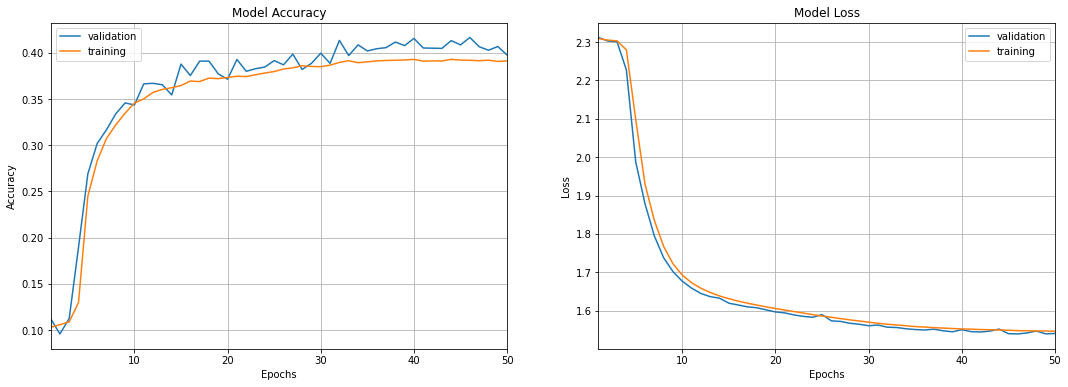

In [7]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 2

### Build the MLP Model: kernel_initializer = ones, activation = sigmoid

In [8]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'ones'
activation = 'sigmoid'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Wall time: 42.9 ms


### Train the MLP Model: SGD learning_rate = 0.1

In [9]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3827 - accuracy: 0.1023 - val_loss: 2.5068 - val_accuracy: 0.1126
Epoch 2/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3749 - accuracy: 0.1003 - val_loss: 2.4203 - val_accuracy: 0.1070
Epoch 3/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3824 - accuracy: 0.1021 - val_loss: 2.5249 - val_accuracy: 0.1002
Epoch 4/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3806 - accuracy: 0.1013 - val_loss: 2.5012 - val_accuracy: 0.0990
Epoch 5/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3838 - accuracy: 0.0986 - val_loss: 2.5983 - val_accuracy: 0.0924
Epoch 6/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3842 - accuracy: 0.1002 - val_loss: 2.5453 - val_accuracy: 0.0986
Epoch 7/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3803 - accuracy: 0.1027 - val_loss: 2.6859 - val_accuracy: 0.1100
Epoch 

### History Object

In [10]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [11]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  12

Test Data: Loss & Accuracy:  [2.5448715686798096, 0.10090000182390213]

Train Accuracy:  0.09916363636363637

Test Accuracy:  0.1009

Test Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0  980]
 [   0    0    0    0    0    0    0    0    0 1135]
 [   0    0    0    0    0    0    0    0    0 1032]
 [   0    0    0    0    0    0    0    0    0 1010]
 [   0    0    0    0    0    0    0    0    0  982]
 [   0    0    0    0    0    0    0    0    0  892]
 [   0    0    0    0    0    0    0    0    0  958]
 [   0    0    0    0    0    0    0    0    0 1028]
 [   0    0    0    0    0    0    0    0    0  974]
 [   0    0    0    0    0    0    0    0    0 1009]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
    

### Plot Learning Curve

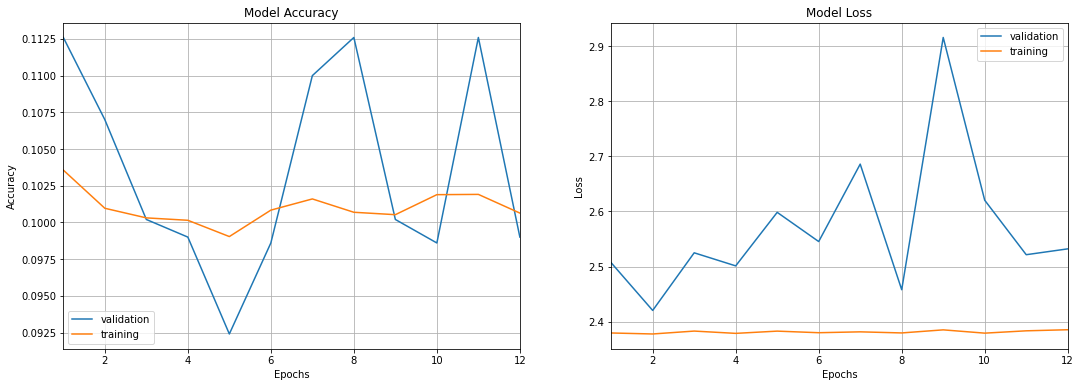

In [12]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 3

### Build the MLP Model: kernel_initializer = random_normal, activation = sigmoid

In [13]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'sigmoid'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Wall time: 115 ms


### Train the MLP Model: SGD learning_rate = 0.1

In [14]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 1s 1ms/step - loss: 2.1119 - accuracy: 0.2591 - val_loss: 0.8378 - val_accuracy: 0.7512
Epoch 2/50
860/860 [==============================] - 1s 1ms/step - loss: 0.7115 - accuracy: 0.7970 - val_loss: 0.4401 - val_accuracy: 0.8812
Epoch 3/50
860/860 [==============================] - 1s 1ms/step - loss: 0.4383 - accuracy: 0.8760 - val_loss: 0.3549 - val_accuracy: 0.8994
Epoch 4/50
860/860 [==============================] - 1s 1ms/step - loss: 0.3631 - accuracy: 0.8965 - val_loss: 0.3192 - val_accuracy: 0.9090
Epoch 5/50
860/860 [==============================] - 1s 1ms/step - loss: 0.3331 - accuracy: 0.9037 - val_loss: 0.2967 - val_accuracy: 0.9154
Epoch 6/50
860/860 [==============================] - 1s 1ms/step - loss: 0.3123 - accuracy: 0.9089 - val_loss: 0.2846 - val_accuracy: 0.9196
Epoch 7/50
860/860 [==============================] - 1s 1ms/step - loss: 0.2912 - accuracy: 0.9170 - val_loss: 0.2601 - val_accuracy: 0.9240
Epoch 

### History Object

In [15]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [16]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [0.08313348889350891, 0.9745000004768372]

Train Accuracy:  0.9854181818181819

Test Accuracy:  0.9745

Test Confusion Matrix:
[[ 962    0    2    2    1    4    4    3    1    1]
 [   0 1125    2    1    0    1    2    2    2    0]
 [   1    2 1007    7    2    0    2    8    3    0]
 [   0    0    4  994    0    2    0    7    2    1]
 [   0    0    2    0  957    1    5    2    0   15]
 [   5    1    0   15    3  857    3    1    4    3]
 [   5    3    0    1    4    3  939    0    3    0]
 [   1    3    8    3    1    0    0 1001    1   10]
 [   2    0    4   17    3    5    5    6  928    4]
 [   3    3    0    8   10    1    1    8    0  975]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.95      0.98      0.97      1010
     

### Plot Learning Curve

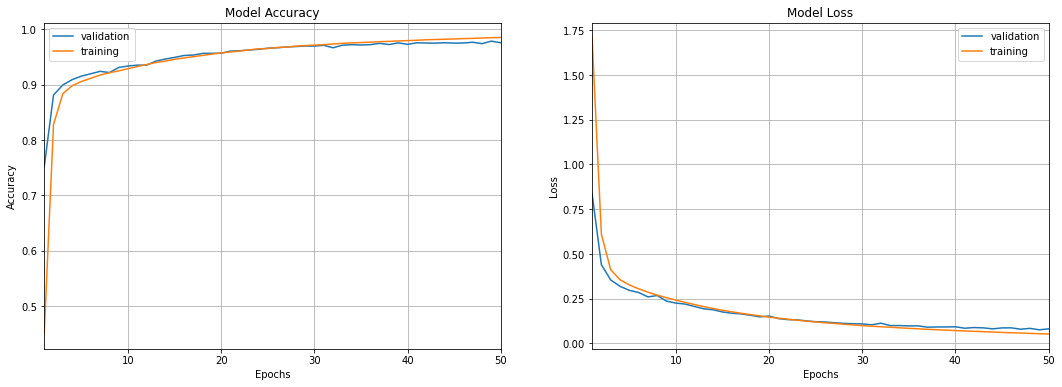

In [17]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 4

### Build the MLP Model: kernel_initializer = random_normal, activation = tanh

In [18]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'tanh'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Wall time: 31.9 ms


### Train the MLP Model: SGD learning_rate = 0.1

In [19]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 2s 1ms/step - loss: 0.6970 - accuracy: 0.8181 - val_loss: 0.2366 - val_accuracy: 0.9330
Epoch 2/50
860/860 [==============================] - 1s 1ms/step - loss: 0.2329 - accuracy: 0.9327 - val_loss: 0.1767 - val_accuracy: 0.9492
Epoch 3/50
860/860 [==============================] - 1s 1ms/step - loss: 0.1749 - accuracy: 0.9474 - val_loss: 0.1369 - val_accuracy: 0.9626
Epoch 4/50
860/860 [==============================] - 1s 1ms/step - loss: 0.1353 - accuracy: 0.9604 - val_loss: 0.1203 - val_accuracy: 0.9666
Epoch 5/50
860/860 [==============================] - 1s 1ms/step - loss: 0.1120 - accuracy: 0.9680 - val_loss: 0.1097 - val_accuracy: 0.9688
Epoch 6/50
860/860 [==============================] - 1s 1ms/step - loss: 0.0947 - accuracy: 0.9722 - val_loss: 0.0985 - val_accuracy: 0.9712
Epoch 7/50
860/860 [==============================] - 1s 1ms/step - loss: 0.0816 - accuracy: 0.9768 - val_loss: 0.0930 - val_accuracy: 0.9734
Epoch 

### History Object

In [20]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [21]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  37

Test Data: Loss & Accuracy:  [0.06661780923604965, 0.982200026512146]

Train Accuracy:  0.9999818181818182

Test Accuracy:  0.9822

Test Confusion Matrix:
[[ 974    0    1    0    0    0    1    1    2    1]
 [   1 1126    1    1    0    1    2    1    2    0]
 [   4    0 1013    2    1    0    1    4    7    0]
 [   0    0    5  993    0    1    0    3    2    6]
 [   1    0    1    0  960    1    6    2    0   11]
 [   4    0    0   10    2  865    5    1    3    2]
 [   5    2    0    1    4    5  939    0    2    0]
 [   2    1    5    2    0    0    0 1011    2    5]
 [   2    0    2    4    3    3    1    2  954    3]
 [   1    2    0    5    6    0    0    6    2  987]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
      

### Plot Learning Curve

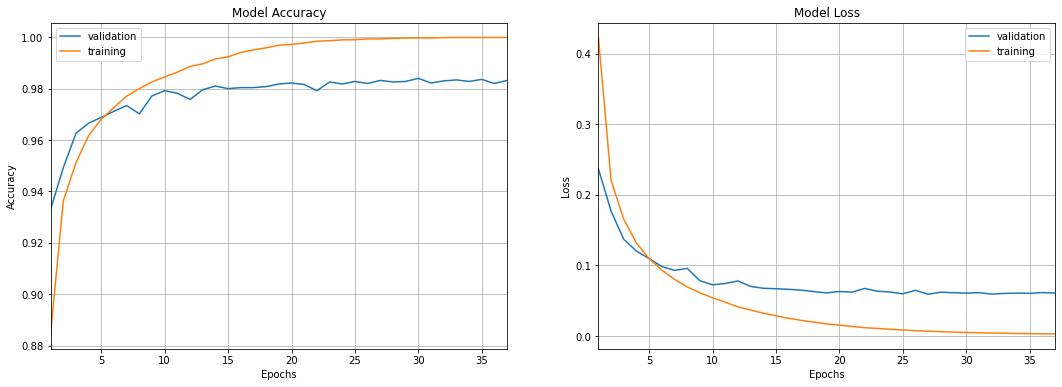

In [22]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 5

### Build the MLP Model: kernel_initializer = random_normal, activation = relu

In [23]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Wall time: 30.9 ms


### Train the MLP Model: SGD learning_rate = 0.1

In [24]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 0.7941 - accuracy: 0.7732 - val_loss: 0.1957 - val_accuracy: 0.9450
Epoch 2/50
860/860 [==============================] - 1s 1ms/step - loss: 0.1896 - accuracy: 0.9444 - val_loss: 0.1430 - val_accuracy: 0.9594
Epoch 3/50
860/860 [==============================] - 1s 1ms/step - loss: 0.1281 - accuracy: 0.9617 - val_loss: 0.1021 - val_accuracy: 0.9718
Epoch 4/50
860/860 [==============================] - 1s 1ms/step - loss: 0.0911 - accuracy: 0.9735 - val_loss: 0.0898 - val_accuracy: 0.9750
Epoch 5/50
860/860 [==============================] - 1s 1ms/step - loss: 0.0713 - accuracy: 0.9798 - val_loss: 0.0864 - val_accuracy: 0.9742
Epoch 6/50
860/860 [==============================] - 1s 1ms/step - loss: 0.0558 - accuracy: 0.9838 - val_loss: 0.0738 - val_accuracy: 0.9774
Epoch 7/50
860/860 [==============================] - 1s 1ms/step - loss: 0.0464 - accuracy: 0.9864 - val_loss: 0.0741 - val_accuracy: 0.9792
Epoch 

### History Object

In [25]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [26]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  20

Test Data: Loss & Accuracy:  [0.06563017517328262, 0.9807999730110168]

Train Accuracy:  0.9999454545454546

Test Accuracy:  0.9808

Test Confusion Matrix:
[[ 967    0    1    0    1    1    2    3    4    1]
 [   0 1126    1    1    0    0    2    1    4    0]
 [   4    2 1006    0    4    0    2    7    7    0]
 [   0    0    3  996    0    2    0    2    3    4]
 [   2    0    3    0  966    0    3    1    0    7]
 [   2    0    0    8    1  870    3    1    5    2]
 [   4    3    1    1    5    3  939    0    2    0]
 [   2    4    6    2    1    0    0 1003    5    5]
 [   4    0    3    3    1    1    3    2  955    2]
 [   2    2    0    6    7    3    1    4    4  980]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.99      0.98      1010
     

### Plot Learning Curve

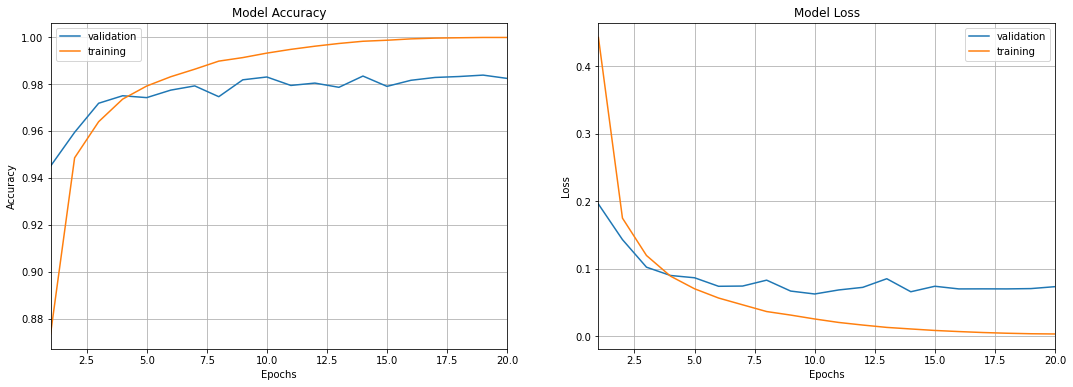

In [27]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 6

### Build the MLP Model: kernel_initializer = random_normal, activation = relu, Hidden layer 1: rate=0.1, Hidden layer 2: rate=0.1

In [28]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
___________________________________

### Train the MLP Model: SGD learning_rate = 0.1

In [29]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 0.8369 - accuracy: 0.7511 - val_loss: 0.1950 - val_accuracy: 0.9454
Epoch 2/50
860/860 [==============================] - 1s 2ms/step - loss: 0.2102 - accuracy: 0.9366 - val_loss: 0.1402 - val_accuracy: 0.9580
Epoch 3/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1493 - accuracy: 0.9553 - val_loss: 0.1000 - val_accuracy: 0.9698
Epoch 4/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1114 - accuracy: 0.9677 - val_loss: 0.0919 - val_accuracy: 0.9732
Epoch 5/50
860/860 [==============================] - 1s 2ms/step - loss: 0.0892 - accuracy: 0.9726 - val_loss: 0.0920 - val_accuracy: 0.9708
Epoch 6/50
860/860 [==============================] - 1s 2ms/step - loss: 0.0754 - accuracy: 0.9772 - val_loss: 0.0761 - val_accuracy: 0.9778
Epoch 7/50
860/860 [==============================] - 1s 2ms/step - loss: 0.0649 - accuracy: 0.9807 - val_loss: 0.0740 - val_accuracy: 0.9794
Epoch 

### History Object

In [30]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [31]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  26

Test Data: Loss & Accuracy:  [0.07191652059555054, 0.9818999767303467]

Train Accuracy:  0.9978363636363636

Test Accuracy:  0.9819

Test Confusion Matrix:
[[ 972    1    1    1    0    0    1    2    1    1]
 [   0 1127    3    0    0    0    2    1    2    0]
 [   1    0 1020    1    2    0    0    4    4    0]
 [   1    0    8  991    0    2    0    4    2    2]
 [   0    0    6    0  969    0    2    2    1    2]
 [   2    0    0   12    1  869    3    1    3    1]
 [   4    3    2    1    2    2  943    0    1    0]
 [   1    2    6    0    0    0    0 1018    1    0]
 [   4    0    4    4    3    1    3    6  949    0]
 [   2    3    0    8   11    0    1   18    5  961]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.97      0.98      0.98      1010
     

### Plot Learning Curve

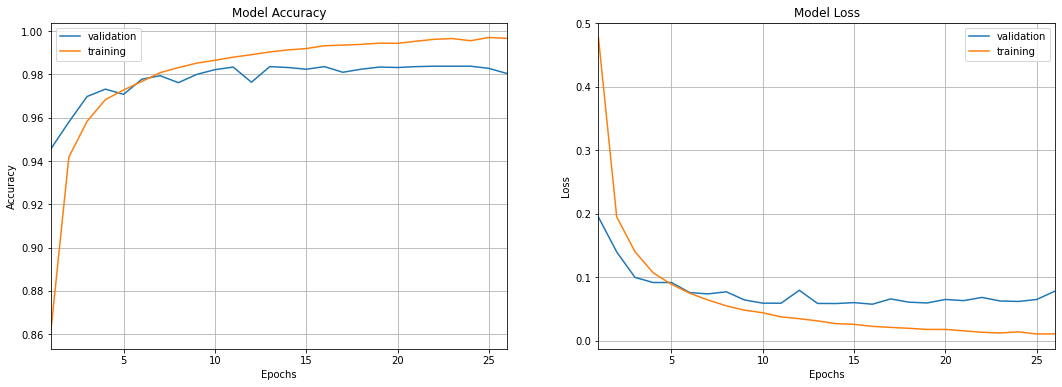

In [32]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 7

### Build the MLP Model: kernel_initializer = random_normal, activation = relu, Hidden layer 1: rate=0.5, Hidden layer 2: rate=0.1

In [33]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dropout(rate=0.5)) # add if needed
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
___________________________________

### Train the MLP Model: SGD learning_rate = 0.1

In [34]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 0.9443 - accuracy: 0.7029 - val_loss: 0.2043 - val_accuracy: 0.9406
Epoch 2/50
860/860 [==============================] - 1s 2ms/step - loss: 0.2704 - accuracy: 0.9166 - val_loss: 0.1451 - val_accuracy: 0.9606
Epoch 3/50
860/860 [==============================] - 1s 2ms/step - loss: 0.2022 - accuracy: 0.9384 - val_loss: 0.1127 - val_accuracy: 0.9674
Epoch 4/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1642 - accuracy: 0.9503 - val_loss: 0.0995 - val_accuracy: 0.9710
Epoch 5/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1443 - accuracy: 0.9551 - val_loss: 0.0919 - val_accuracy: 0.9726
Epoch 6/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1288 - accuracy: 0.9593 - val_loss: 0.0855 - val_accuracy: 0.9756
Epoch 7/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1160 - accuracy: 0.9647 - val_loss: 0.0806 - val_accuracy: 0.9758
Epoch 

### History Object

In [35]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [36]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  35

Test Data: Loss & Accuracy:  [0.05755094066262245, 0.983299970626831]

Train Accuracy:  0.9980909090909091

Test Accuracy:  0.9833

Test Confusion Matrix:
[[ 973    0    0    0    0    3    1    1    2    0]
 [   0 1124    3    1    0    1    3    1    2    0]
 [   3    0 1014    4    2    0    1    5    3    0]
 [   1    0    3  997    0    1    0    4    3    1]
 [   2    0    1    0  960    0    4    4    0   11]
 [   2    0    0    7    0  875    3    0    4    1]
 [   6    2    0    1    2    4  941    0    2    0]
 [   2    4    7    0    0    0    0 1012    1    2]
 [   6    0    1    3    3    1    0    3  953    4]
 [   4    2    0    3    8    3    0    5    0  984]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
      

### Plot Learning Curve

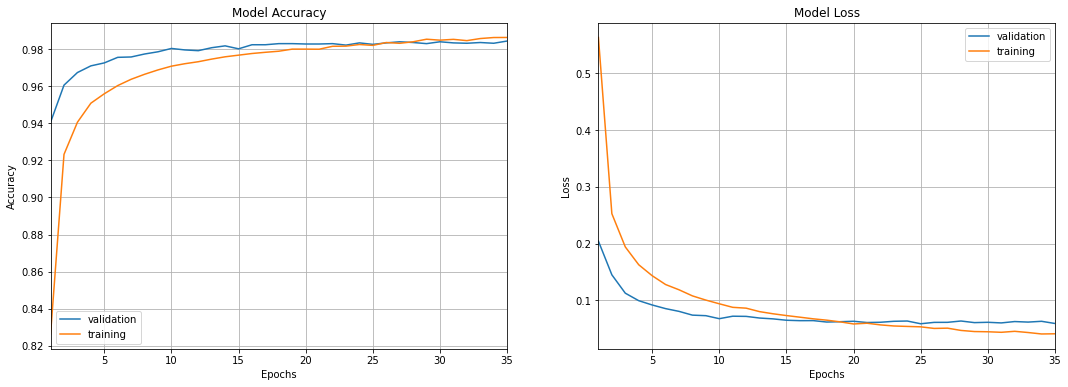

In [37]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 8

### Build the MLP Model: kernel_initializer = random_normal, activation = relu, Hidden layer 1: rate=0.5, Hidden layer 2: rate=0.1 

In [38]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dropout(rate=0.5)) # add if needed
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
model.add(keras.layers.Dropout(rate=0.1)) # add if needed
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
___________________________________

### Train the MLP Model: SGD learning_rate = 0.5

In [39]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.5)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 0.6664 - accuracy: 0.7824 - val_loss: 0.1416 - val_accuracy: 0.9586
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 0.2137 - accuracy: 0.9352 - val_loss: 0.2756 - val_accuracy: 0.9252
Epoch 3/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1766 - accuracy: 0.9464 - val_loss: 0.0857 - val_accuracy: 0.9736
Epoch 4/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1486 - accuracy: 0.9546 - val_loss: 0.1259 - val_accuracy: 0.9586
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 0.1340 - accuracy: 0.9589 - val_loss: 0.0824 - val_accuracy: 0.9752
Epoch 6/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1272 - accuracy: 0.9618 - val_loss: 0.0807 - val_accuracy: 0.9788
Epoch 7/50
860/860 [==============================] - 1s 2ms/step - loss: 0.1158 - accuracy: 0.9653 - val_loss: 0.0874 - val_accuracy: 0.9768
Epoch 

### History Object

In [40]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [41]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  25

Test Data: Loss & Accuracy:  [0.06553743034601212, 0.9811000227928162]

Train Accuracy:  0.9945090909090909

Test Accuracy:  0.9811

Test Confusion Matrix:
[[ 971    1    0    1    1    0    3    1    2    0]
 [   0 1128    1    0    0    1    2    1    2    0]
 [   1    1 1015    0    4    0    2    4    4    1]
 [   0    0    9  982    0    4    0    4    7    4]
 [   0    1    1    0  961    0    6    1    1   11]
 [   2    0    0    7    1  872    2    1    5    2]
 [   3    3    0    1    3    8  937    0    3    0]
 [   1    5    6    1    1    0    0 1004    5    5]
 [   2    0    1    3    2    1    2    2  959    2]
 [   4    2    0    3    7    4    1    3    3  982]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.98      1010
     

### Plot Learning Curve

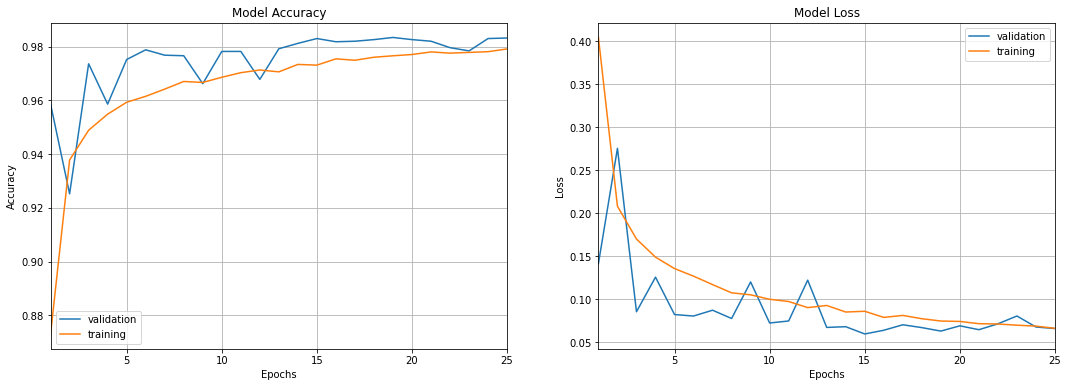

In [42]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 9

### Build the MLP Model: kernel_initializer = random_normal, activation = relu, 10 hidden layers each 100 neurons

In [43]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100) 

### Train the MLP Model: SGD learning_rate = 0.1

In [44]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3018 - accuracy: 0.1115 - val_loss: 2.3013 - val_accuracy: 0.1126
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3011 - accuracy: 0.1158 - val_loss: 2.3006 - val_accuracy: 0.1126
Epoch 3/50
860/860 [==============================] - 1s 2ms/step - loss: 2.3011 - accuracy: 0.1157 - val_loss: 2.3011 - val_accuracy: 0.1126
Epoch 4/50
860/860 [==============================] - 1s 2ms/step - loss: 2.3014 - accuracy: 0.1133 - val_loss: 2.3012 - val_accuracy: 0.1126
Epoch 5/50
860/860 [==============================] - 1s 1ms/step - loss: 2.3015 - accuracy: 0.1134 - val_loss: 2.3023 - val_accuracy: 0.1126
Epoch 6/50
860/860 [==============================] - 1s 2ms/step - loss: 2.3016 - accuracy: 0.1135 - val_loss: 2.3013 - val_accuracy: 0.1126
Epoch 7/50
860/860 [==============================] - 1s 2ms/step - loss: 2.3015 - accuracy: 0.1111 - val_loss: 2.3012 - val_accuracy: 0.1126
Epoch 

### History Object

In [45]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [46]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  12

Test Data: Loss & Accuracy:  [2.3012092113494873, 0.11349999904632568]

Train Accuracy:  0.11234545454545454

Test Accuracy:  0.1135

Test Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
    

### Plot Learning Curve

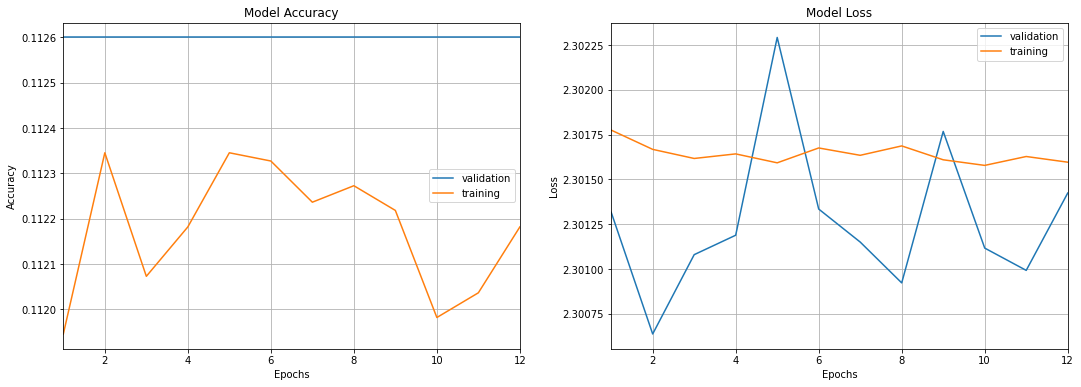

In [47]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment 10

### Build the MLP Model: kernel_initializer = random_normal, activation = relu, 20 hidden layers each 100 neurons

In [48]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))
model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100) 

### Train the MLP Model: SGD learning_rate = 0.1

In [49]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 2.3018 - accuracy: 0.1109 - val_loss: 2.3013 - val_accuracy: 0.1126
Epoch 2/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3011 - accuracy: 0.1158 - val_loss: 2.3006 - val_accuracy: 0.1126
Epoch 3/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3011 - accuracy: 0.1157 - val_loss: 2.3011 - val_accuracy: 0.1126
Epoch 4/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3014 - accuracy: 0.1133 - val_loss: 2.3012 - val_accuracy: 0.1126
Epoch 5/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3015 - accuracy: 0.1134 - val_loss: 2.3023 - val_accuracy: 0.1126
Epoch 6/50
860/860 [==============================] - 2s 2ms/step - loss: 2.3016 - accuracy: 0.1135 - val_loss: 2.3013 - val_accuracy: 0.1126
Epoch 7/50
860/860 [==============================] - 2s 3ms/step - loss: 2.3015 - accuracy: 0.1111 - val_loss: 2.3011 - val_accuracy: 0.1126
Epoch 

### History Object

In [50]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 860}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Evaluate the Model

In [51]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  12

Test Data: Loss & Accuracy:  [2.30120849609375, 0.11349999904632568]

Train Accuracy:  0.11234545454545454

Test Accuracy:  0.1135

Test Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
      

### Plot Learning Curve

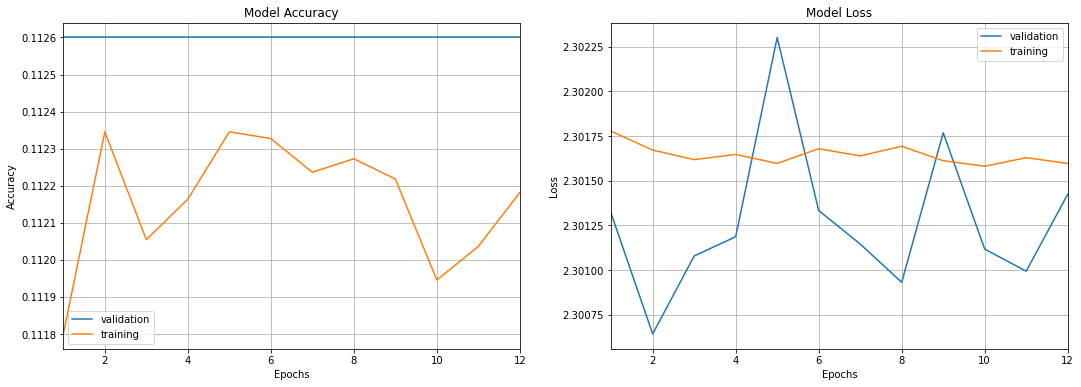

In [52]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

### Q-1) Among experiments 1 to 5, which experiment performed the best (based ontest accuracy & epochs)? Explain why.

Experiment 5.

### Q-2) Among experiments 1 to 5, which experiment performed the worst (based on test accuracy)? Explain why.

Experiment 2.

### Q-3) Compare experiment 6 with experiment 7 and determine which model experiences less overfitting. Explain why. To answer this question, use the train accuracy, test accuracy, and learning curves of these two experiments. In your answer show these measures.

Experiment 7.

### Q-4) Compare experiment 7 with experiment 8. Explain the change in the numberof epochs in experiment 8. If it increased, explain why. If it decreased, explain why.

### Q-5) Compare experiment 8 with experiment 9. Show the accuracy learning curves of these two models. Explain the difference. Which model performed poorly? Explain why.

### Q-6) Compare experiment 9 with experiment 10. Which model performed poorly? Explain why.